In [1]:
# Imports
import audio_processing as ap
from sklearn.preprocessing import normalize
import numpy as np
from network import ContinuousHopfieldNetwork
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile

In [2]:
# Generate sine waves (and save as wav files)

# Dictionary with all the frequencies and their associatd piano pitches
piano_frequencies = {
    55.00: 'A1', 58.27: 'A#1/Bb1',
    61.74: 'B1', 
    65.41: 'C2', 69.30: 'C#2/Db2',
    73.42: 'D2', 77.78: 'D#2/Eb2',
    82.41: 'E2', 87.31: 'F2', 92.50: 'F#2/Gb2',
    98.00: 'G2', 103.83: 'G#2/Ab2',
    110.00: 'A2', 116.54: 'A#2/Bb2',
    123.47: 'B2',
    130.81: 'C3', 138.59: 'C#3/Db3',
    146.83: 'D3', 155.56: 'D#3/Eb3',
    164.81: 'E3', 174.61: 'F3', 185.00: 'F#3/Gb3',
    196.00: 'G3', 207.65: 'G#3/Ab3',
    220.00: 'A3', 233.08: 'A#3/Bb3',
    246.94: 'B3',
    261.63: 'C4', 277.18: 'C#4/Db4',
    293.66: 'D4', 311.13: 'D#4/Eb4',
    329.63: 'E4', 349.23: 'F4', 369.99: 'F#4/Gb4',
    392.00: 'G4', 415.30: 'G#4/Ab4',
    440.00: 'A4', 466.16: 'A#4/Bb4',
    493.88: 'B4',
    523.25: 'C5', 554.37: 'C#5/Db5',
    587.33: 'D5', 622.25: 'D#5/Eb5',
    659.25: 'E5', 698.46: 'F5', 739.99: 'F#5/Gb5',
    783.99: 'G5', 830.61: 'G#5/Ab5',
    880.00: 'A5', 932.33: 'A#5/Bb5',
    987.77: 'B5',
    1046.50: 'C6', 1108.73: 'C#6/Db6',
    1174.66: 'D6', 1244.51: 'D#6/Eb6',
    1318.51: 'E6', 1396.91: 'F6', 1479.98: 'F#6/Gb6',
    1567.98: 'G6', 1661.22: 'G#6/Ab6',
    1760.00: 'A6'
}

clean_folder_path = "./audio/original_sine_waves/"

for frequency in piano_frequencies:
    file_name = clean_folder_path + f"{frequency}.wav"
    ap.generate_sine_wave_file(file_name, frequency=frequency)

In [3]:
# Add noise to sine waves (and save as wav files)

noisy_folder_path = "./audio/noisy_sine_waves/"

for frequency in piano_frequencies:
    clean_file = clean_folder_path + f"{frequency}.wav"
    noisy_file = noisy_folder_path + f"{frequency}.wav"
    ap.add_noise_to_wav(clean_file, noisy_file, noise_level=100000)

In [4]:
# Preprocess into a train and test dataset

train_data = []
test_data = []

mel_bins = 20000 # Hyperparameter

for frequency in list(piano_frequencies.keys()): # Slice for reduced size
    clean_file = clean_folder_path + f"{frequency}.wav"
    noisy_file = noisy_folder_path + f"{frequency}.wav"

    # Read wavfiles
    sample_rate, clean_signal = wavfile.read(clean_file)
    _, noisy_signal = wavfile.read(noisy_file)

    # Take the fourier transform
    clean_mags = np.abs(np.fft.fft(clean_signal))
    noisy_mags = np.abs(np.fft.fft(noisy_signal))

    # Get the frequency bins
    clean_freqs = np.fft.fftfreq(len(clean_signal), d=1/sample_rate)
    noisy_freqs = np.fft.fftfreq(len(noisy_signal), d=1/sample_rate)

    # Restrict to positive freqs
    clean_freqs = clean_freqs[:len(clean_freqs)//2]
    clean_mags = clean_mags[:len(clean_freqs)]
    noisy_freqs = noisy_freqs[:len(noisy_freqs)//2]
    noisy_mags = noisy_mags[:len(noisy_freqs)]

    #print(f"{frequency}: \n {clean_mags}")

    # Normalize the data (no need to binarize since using CHN)
    clean_norm = normalize(clean_mags.reshape(-1,1), axis=0)
    noisy_norm = normalize(noisy_mags.reshape(-1,1), axis=0)

    # No need to flatten since already flat with continuous implementation

    # Add to dataset
    train_data.append(np.array(clean_norm).squeeze())
    test_data.append(np.array(noisy_norm).squeeze())
    
# Convert to numpy
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_data.shape)

(61, 22050)


In [5]:
# Initialize and train Hopfield net on clean audio
model = ContinuousHopfieldNetwork()

model.train(train_data)

In [6]:
# No weights to plot since CHN

In [7]:
# Get predictions with the Hopfield net from the noisy audio
print(train_data.shape)
predictions = model.predict(test_data, beta=100, num_iter=1)

(61, 22050)


100%|██████████| 61/61 [00:00<00:00, 633.88it/s]


100%|██████████| 61/61 [00:00<00:00, 327.69it/s]


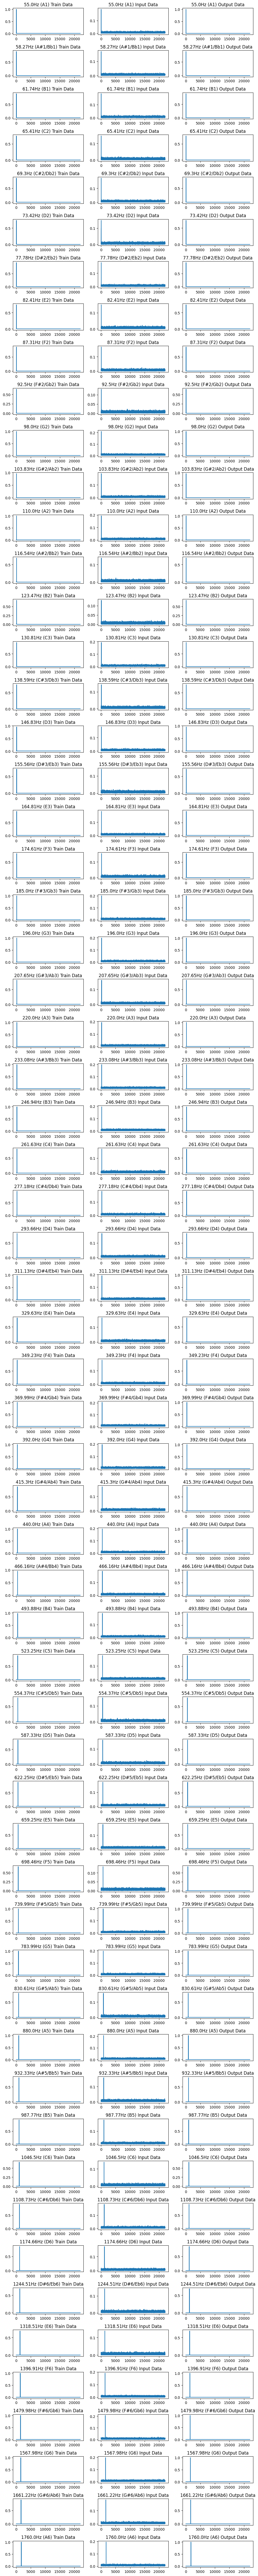

In [8]:
# Plot some example training vs predictions

figure, axes = plt.subplots(len(predictions), 3, figsize=(10,100))

freq_keys = list(piano_frequencies.keys())

c = 0
for i in tqdm(range(0, len(predictions))):
    original = train_data[i]
    noisy = test_data[i]
    cleaned = predictions[i]

    axes[c, 0].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Train Data")
    axes[c, 1].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Input Data")
    axes[c, 2].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Output Data")

    axes[c, 0].plot(clean_freqs, original)
    axes[c, 1].plot(clean_freqs, noisy)
    axes[c, 2].plot(clean_freqs, cleaned)
    
    c += 1

plt.tight_layout()
plt.savefig("./figures/continuous_analysis/predictions.png")
plt.show()


In [9]:
# Find mean absolute prediction error
print(train_data.shape)
print(predictions.shape)
mae = np.mean(np.sum(np.abs(train_data-predictions), axis=1))
print(mae)

num = 50

pred_ind = np.where(predictions[num]==np.max(predictions[num]))
train_ind = np.where(train_data[num]==np.max(train_data[num]))

print(f"Max train mag of: {train_data[num][train_ind]} at {train_ind}")
print(f"Max pred mag of: {predictions[num][pred_ind]} at {pred_ind}")

print(f"Given freq: {clean_freqs[train_ind[0][0]]}")
print(f"Predicted freq: {clean_freqs[pred_ind[0][0]]}")

(61, 22050)
(61, 22050)
8.072631425042967e-06
Max train mag of: [0.93060208] at (array([988]),)
Max pred mag of: [0.93060165] at (array([988]),)
Given freq: 988.0
Predicted freq: 988.0


In [10]:
for i, frequency in enumerate(piano_frequencies):
    file_name =  f"./audio/cleaned_sine_waves/{frequency}.wav"
    # Take the inverse Fourier transform to get time-domain signal
    reconstructed_signal = np.fft.irfft(predictions[i])

    reconstructed_signal /= np.max(np.abs(reconstructed_signal))

    # Scale the signal to the appropriate range for 16-bit PCM WAV files
    scaled_signal = np.int16(reconstructed_signal * 32767)
    wavfile.write(file_name, 44100, scaled_signal)

In [11]:
# Make some plots showing how recovery accuracy changes with hyperparameters (noise level, threshold, num_iter, etc)

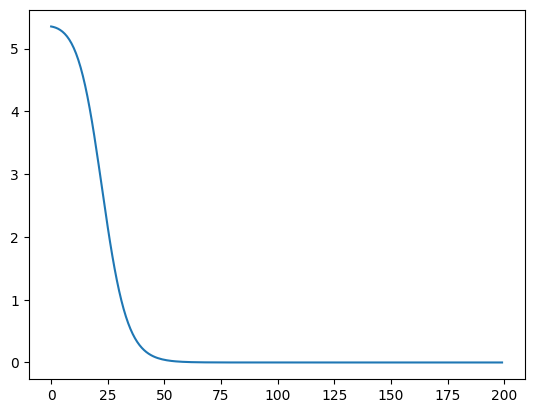

In [12]:
# Temperature
temps = np.arange(200)
mae_arr = []

for temp in temps:
    pred = model.predict(test_data, beta=temp, num_iter=1, hide_output=True)
    mae = np.mean(np.sum(np.abs(train_data-pred), axis=1))
    mae_arr.append(mae)

plt.plot(temps, mae_arr)
plt.show()

100%|██████████| 1000/1000 [04:06<00:00,  4.06it/s]


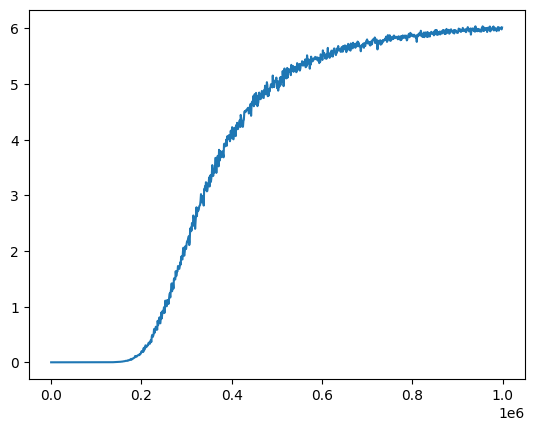

In [13]:
# Noise level
noise_levels = np.arange(0, 1000000, 1000)
mae_noise_arr = []

for noise_level in tqdm(noise_levels):
    clean_folder_path = f"./audio/original_sine_waves/"
    noisy_folder_path = f"./audio/noise_levels/{noise_level}/"
    test_data = []
    for frequency in piano_frequencies:
        clean_file = clean_folder_path + f"{frequency}.wav"
        noisy_file = noisy_folder_path + f"{frequency}.wav"
        ap.add_noise_to_wav(clean_file, noisy_file, noise_level=noise_level)
        
        # Prep test data
        sample_rate, noisy_signal = wavfile.read(noisy_file)
        noisy_mags = np.abs(np.fft.fft(noisy_signal))
        noisy_freqs = np.fft.fftfreq(len(noisy_signal), d=1/sample_rate)
        noisy_freqs = noisy_freqs[:len(noisy_freqs)//2]
        noisy_mags = noisy_mags[:len(noisy_freqs)]
        noisy_norm = normalize(noisy_mags.reshape(-1,1), axis=0)
        
        test_data.append(np.array(noisy_norm).squeeze())
    
    # Convert to numpy
    test_data = np.array(test_data)
    pred = model.predict(test_data, beta=100, hide_output=True)
    mae = np.mean(np.sum(np.abs(train_data-pred), axis=1))
    mae_noise_arr.append(mae)

plt.plot(noise_levels, mae_noise_arr)
plt.show()


In [14]:
# Make some plots showing how recovery accuracy changes with number of memories stored